In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
image_size = 256
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(means, stds)])

In [3]:
def load_image(path, transform):
    image = Image.open(path)
    image = transform(image)
    return image

In [4]:
content_image = load_image('assets/dancing.jpg', transform)
style_image = load_image('assets/picasso.jpg', transform)

In [5]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def show_image(image):
    image = image.detach().clone()
    image = normalize_image(image)
    image = image.cpu().permute(1,2,0).numpy()
    plt.axis('off')
    plt.imshow(image)

def save_image(name, image):
    image = image.detach().clone()
    image = normalize_image(image)
    image = image.cpu().permute(1,2,0).numpy()
    plt.axis('off')
    plt.imsave(name, image)

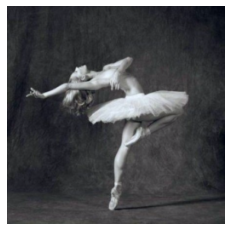

In [6]:
show_image(content_image)

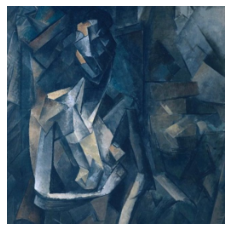

In [7]:
show_image(style_image)

In [8]:
def get_content_loss(features, target):
    loss = F.mse_loss(features, target.detach())
    return loss

In [9]:
def get_gram_matrix(x):
    b, c, h, w = x.shape
    x = x.view(b * c, h * w)
    g = torch.mm(x, x.t())
    g = g.div(b * c * h * w)
    return g

def get_style_loss(features, target):
    g_features = get_gram_matrix(features)
    g_target = get_gram_matrix(target)
    loss = F.mse_loss(g_features, g_target.detach())
    return loss

In [10]:
vgg = models.vgg19(pretrained = True).features.eval()

In [11]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [12]:
class VGG(nn.Module):
    def __init__(self, vgg, content_layers, style_layer):
        super().__init__()
        assert isinstance(vgg, nn.Sequential)
        self.content_layers = set(content_layers)
        self.style_layers = set(style_layers)
        max_layers = max(max(content_layers), max(style_layers))
        self.vgg = vgg[:max_layers+1]

    def forward(self, x):
        content_features = []
        style_features = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in content_layers:
                content_features.append(x)
            if i in style_layers:
                style_features.append(x)
        return content_features, style_features

In [13]:
content_layers = [7]
style_layers = [0, 2, 5, 7, 10]

model = VGG(vgg, content_layers, style_layers)

In [14]:
input_image = content_image.clone().requires_grad_()

In [15]:
optimizer = optim.LBFGS([input_image])

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
content_image = content_image.to(device)
style_image = style_image.to(device)
input_image = input_image.to(device)

In [17]:
content_image = content_image.unsqueeze(0).to(device)
style_image = style_image.unsqueeze(0).to(device)
input_image = input_image.unsqueeze(0).to(device)

100%|██████████| 300/300 [00:17<00:00, 17.11it/s]


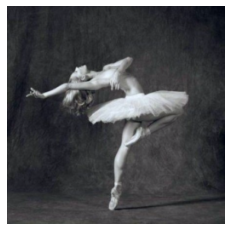

In [18]:
n_steps = 300
content_weight = 1
style_weight = 1_000_000

for i in tqdm(range(n_steps)):

    def closure():

        optimizer.zero_grad()

        content_content_features, content_style_features = model(content_image)
        style_content_features, style_style_features = model(style_image)
        input_content_features, input_style_features = model(input_image)

        content_loss = 0

        for input_features, content_features in zip(input_content_features, content_content_features):
            content_loss += get_content_loss(input_features, content_features)

        style_loss = 0

        for input_features, style_features in zip(input_style_features, style_style_features):
            style_loss += get_style_loss(input_features, style_features)

        content_loss = content_weight * content_loss
        style_loss = style_weight * style_loss

        loss = content_loss + style_loss

        loss.backward()

        return loss

    optimizer.step(closure)

    show_image(input_image.squeeze())
    save_image(f'{i+1}.png', input_image.squeeze())